# Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.checkpoint import checkpoint

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

if device == 'cuda': print(torch.cuda.get_device_name())

cuda


# Physics Informed Neural Network

In [2]:
class PINN(nn.Module):
    """
    Physics-Informed Neural Network (PINN) for solving the Gross-Pitaevskii equation (GPE).

    Attributes
    ----------
    layers : nn.ModuleList
        List of neural network layers.
    ub : torch.Tensor
        Upper bound for input normalization.
    lb : torch.Tensor
        Lower bound for input normalization.
    adaptive_bc_scale : torch.nn.Parameter
        Learnable scaling factor for boundary condition loss.
    hbar : torch.nn.Parameter
        Learnable or fixed parameter for Planck's constant.
    m : torch.nn.Parameter
        Learnable parameter for particle mass.
    g : torch.nn.Parameter
        Learnable parameter for interaction strength.
    """

    def __init__(self, layers, ub, lb, hbar=6.62607015e-34):
        """
        Initializes the PINN model with given layer sizes and boundary conditions.

        Parameters
        ----------
        layers : list
            List of integers specifying the number of units in each layer.
        ub : list or numpy.ndarray
            Upper bounds of the input domain for feature normalization.
        lb : list or numpy.ndarray
            Lower bounds of the input domain for feature normalization.
        hbar : float, optional
            Planck's constant, default is the physical value in J⋅Hz−1.
        """
        super(PINN, self).__init__()
        self.layers = nn.ModuleList()
        self.ub = torch.tensor(ub, dtype=torch.float32, device=device)
        self.lb = torch.tensor(lb, dtype=torch.float32, device=device)

        self.adaptive_bc_scale = nn.Parameter(torch.tensor(1.0, device=device))  # Adaptive weighting for BC loss (lambda)
        self.hbar = hbar  # Planck's constant (fixed or learnable?)
        self.m = nn.Parameter(torch.tensor(1.0, device=device))  # Learnable mass parameter
        self.g = nn.Parameter(torch.tensor(1.0, device=device))  # Learnable interaction strength

        # Define network layers
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i + 1]))
            if i < len(layers) - 2:
                self.layers.append(nn.LeakyReLU())

        self.activation = nn.LeakyReLU()
        self.init_weights()

    def init_weights(self):
        """ Initialize weights using Xavier initialization. """
        for m in self.layers:
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)

    def forward(self, x):
        """
        Forward pass through the neural network.

        Parameters
        ----------
        x : torch.Tensor
            Input tensor for the neural network.

        Returns
        -------
        torch.Tensor
            Output of the neural network after forward pass.
        """

        # Ensure lb and ub are broadcastable to the shape of x
        lb = self.lb.view(1, -1)  # Ensure lb shape is (1, num_features)
        ub = self.ub.view(1, -1)  # Ensure ub shape is (1, num_features)

        # Normalize the inputs
        x = (x - lb) / (ub - lb)

        # Use gradient checkpointing for layers to save memory
        for i, layer in enumerate(self.layers):
            if i % 2 == 0:  # Apply checkpointing only to Linear layers
                x = checkpoint(layer, x, use_reentrant=False)
            else:
                x = layer(x)

        return x

    def loss_BC(self, x_bc, y_bc):
        """
        Computes the boundary condition (BC) loss.

        Parameters
        ----------
        x_bc : torch.Tensor
            Boundary condition input data.
        y_bc : torch.Tensor
            Boundary condition output (true) values.

        Returns
        -------
        torch.Tensor
            Scaled mean squared error (MSE) loss for boundary conditions.
        """
        u_pred = self.forward(x_bc)
        adaptive_scale = self.adaptive_bc_scale  # Adaptive scaling
        bc_loss = adaptive_scale * torch.mean((u_pred - y_bc) ** 2)
        return bc_loss

    def riesz_loss(self, predictions, inputs):
        """
        Computes the Riesz energy loss for regularization.

        Parameters
        ----------
        predictions : torch.Tensor
            Model predictions.
        inputs : torch.Tensor
            Input points.

        Returns
        -------
        torch.Tensor
            Riesz energy loss.
        """
        if not inputs.requires_grad:
            inputs = inputs.clone().detach().requires_grad_(True)
        gradients = torch.autograd.grad(outputs=predictions, inputs=inputs,
                                        grad_outputs=torch.ones_like(predictions),
                                        create_graph=True, retain_graph=True)[0]
        riesz_energy = torch.sum(gradients ** 2)
        return riesz_energy

    def pde_loss(self, inputs, predictions):
        """
        Computes the PDE loss for the 2D Gross-Pitaevskii equation:

        i * hbar * dψ/dt = (-hbar^2/2m) * (∇²ψ) + V(x, y)ψ + g|ψ|²ψ.

        Assume that we're solving the time-independent GPE, so the loss becomes:

        - hbar^2/(2m) * (∇²ψ) + V(x, y)ψ + g|ψ|²ψ = 0.

        Parameters
        ----------
        inputs : torch.Tensor
            Input points (x, y).
        predictions : torch.Tensor
            Predicted output from the network, representing the wave function ψ.

        Returns
        -------
        torch.Tensor
            Gross-Pitaevskii PDE loss.
        """
        # Calculate gradients of ψ with respect to inputs
        psi = predictions
        psi_x = torch.autograd.grad(psi, inputs, grad_outputs=torch.ones_like(psi), create_graph=True)[0]

        # Second derivatives of the Laplacian (∇²ψ)
        psi_xx = torch.autograd.grad(psi_x[:, 0], inputs, grad_outputs=torch.ones_like(psi_x[:, 0]), create_graph=True)[0][:, 0]
        psi_yy = torch.autograd.grad(psi_x[:, 1], inputs, grad_outputs=torch.ones_like(psi_x[:, 1]), create_graph=True)[0][:, 1]

        # Laplacian ∇²ψ
        laplacian_psi = psi_xx + psi_yy

        # Gross-Pitaevskii equation residual: hbar^2/(2m) * (∇²ψ) - g|ψ|²ψ
        pde_residual = (- self.hbar ** 2 / (2 * self.m)) * laplacian_psi + self.g * torch.abs(psi) ** 2 * psi

        # PDE loss: Mean squared error of the residual
        pde_loss = torch.mean(pde_residual ** 2)

        return pde_loss

    def loss(self, x_bc, y_bc, x_to_train_f):
        """
        Computes the total loss combining BC loss, PDE loss (Helmholtz), and Riesz loss.

        Parameters
        ----------
        x_bc : torch.Tensor
            Boundary condition input data.
        y_bc : torch.Tensor
            Boundary condition true values.
        x_to_train_f : torch.Tensor
            Input points for PDE training.

        Returns
        -------
        torch.Tensor
            Total loss combining BC, PDE, and Riesz losses.
        """
        loss_u = self.adaptive_bc_scale * self.loss_BC(x_bc, y_bc)  # BC loss
        predictions = self.forward(x_to_train_f)

        # PDE loss (Helmholtz equation) with learnable k
        loss_pde = self.pde_loss(x_to_train_f, predictions)

        # Riesz energy loss for smoothness
        loss_k = self.riesz_loss(predictions, x_to_train_f)

        total_loss = loss_u + loss_pde + loss_k
        return total_loss

# Training PINN

In [7]:
def train_pinn(model, optimizer, scheduler, x_bc, y_bc, x_to_train_f, epochs):
    """
    Training loop for the PINN model.

    Parameters
    ----------
    model : PINN
        PINN model to be trained.
    optimizer : torch.optim.Optimizer
        Optimizer for training.
    scheduler : torch.optim.lr_scheduler
        Learning rate scheduler.
    x_bc : torch.Tensor
        Boundary condition input data.
    y_bc : torch.Tensor
        Boundary condition output data.
    x_to_train_f : torch.Tensor
        Input points for PDE training.
    epochs : int
        Number of training epochs.
    """

    scaler = torch.amp.GradScaler('cuda')  # Mixed precision training

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        with torch.amp.autocast('cuda'):  # Use mixed precision for forward pass
            loss = model.loss(x_bc, y_bc, x_to_train_f)

        scaler.scale(loss).backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        scaler.step(optimizer)
        scaler.update()
        scheduler.step(loss)

        if epoch % 100 == 0:
            print(f'Epoch {epoch}/{epochs}, Loss: {loss.item()}, Learned Adaptive BC: {model.adaptive_bc_scale.item()}')

# *Solution Plot*

In [8]:
def visualize_solution(model, x_train, y_train):
    """
    Visualizes the predicted solution from the Physics-Informed Neural Network (PINN).

    The plot shows the network's predicted solution over the 2D spatial domain.

    Parameters
    ----------
    model : PINN
        The trained PINN model used for predictions.
    x_train : torch.Tensor
        Training points used for prediction. Should be a tensor of shape (N, 1).
    y_train : torch.Tensor
        Training points used for prediction. Should be a tensor of shape (N, 1).
    """
    # Flatten the grid of x_train and y_train
    x_flat = x_train.reshape(-1, 1)
    y_flat = y_train.reshape(-1, 1)

    # Generate predictions using the model
    with torch.no_grad():  # Don't track gradients for visualization
        inputs = torch.cat([x_flat, y_flat], dim=1)  # Combine x and y into a 2D tensor
        u_pred = model(inputs)  # Get the model's predictions

    # Detach the predictions and convert to numpy
    x_train = x_train.detach().cpu().numpy()
    y_train = y_train.detach().cpu().numpy()
    u_pred = u_pred.detach().cpu().numpy().reshape(x_train.shape)

    # Create a grid
    x_unique = np.unique(x_train)
    y_unique = np.unique(y_train)
    X, Y = np.meshgrid(x_unique, y_unique)

    # Plotting the predicted solution
    fig, ax = plt.subplots(figsize=(8, 6))

    # Surface plot of predicted solution
    c = ax.pcolor(X, Y, u_pred, cmap='jet')
    fig.colorbar(c, ax=ax)

    ax.set_xlabel(r'$x$ (Spatial Coordinate)', fontsize=12)
    ax.set_ylabel(r'$y$ (Spatial Coordinate)', fontsize=12)

    ax.set_title('Predicted Solution from PINN after Training\n(Prediction over the Spatial Domain)', fontsize=14)
    plt.tight_layout()
    plt.show()

# Main

Epoch 0/1000, Loss: 50.774166107177734, Learned Adaptive BC: 1.0
Epoch 100/1000, Loss: 0.0002026392612606287, Learned Adaptive BC: -0.029932012781500816
Epoch 200/1000, Loss: 8.235792847699486e-08, Learned Adaptive BC: 0.000151156957144849
Epoch 300/1000, Loss: 1.3005682752975645e-08, Learned Adaptive BC: 2.676742383300734e-07
Epoch 400/1000, Loss: 1.0885266021887219e-08, Learned Adaptive BC: -5.5508726504172046e-09
Epoch 500/1000, Loss: 1.213340539152341e-09, Learned Adaptive BC: 2.8566145976460788e-11
Epoch 600/1000, Loss: 2.763599127320049e-09, Learned Adaptive BC: 1.8491439052171176e-14
Epoch 700/1000, Loss: 5.128775626417337e-09, Learned Adaptive BC: -5.825241454636876e-16
Epoch 800/1000, Loss: 2.0584955962021922e-09, Learned Adaptive BC: 1.227644493086514e-18
Epoch 900/1000, Loss: 4.3820662654070475e-09, Learned Adaptive BC: 9.885252606470501e-21


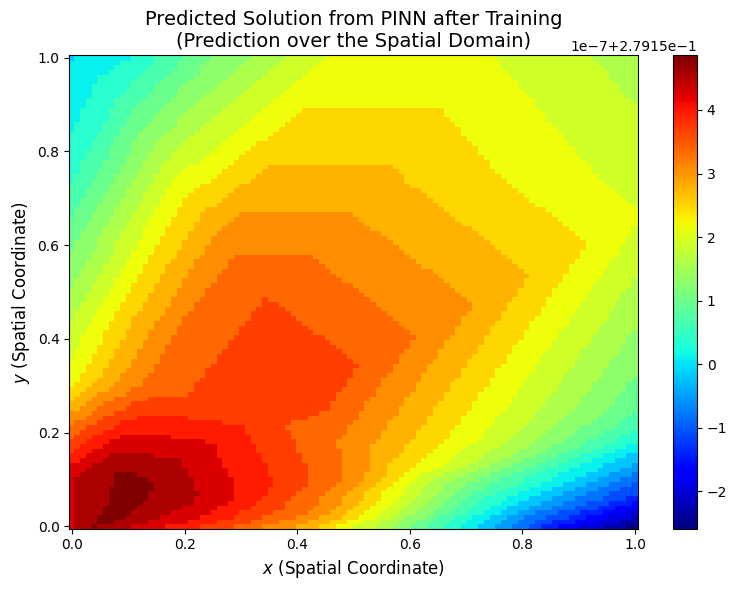

In [9]:
# Input parameters
ub = np.array([1, 1])
lb = np.array([0.0, 0.0])
layers = [2, 40, 40, 40, 40, 1]  # Neural network layers
epochs = 1000

# Training data (boundary condition points)
x_train = torch.linspace(0.0, 1.0, 100, device=device).view(-1, 1).requires_grad_(True)
y_train = torch.linspace(0.0, 1.0, 100, device=device).view(-1, 1).requires_grad_(True)
x_train, y_train = torch.meshgrid(x_train.squeeze(), y_train.squeeze(), indexing='ij')
x_bc, y_bc = x_train.reshape(-1, 1), y_train.reshape(-1, 1)

# Model initialization
model = PINN(layers, ub=ub, lb=lb).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=200, factor=0.5, verbose=True)

# Train the model
train_pinn(model, optimizer, scheduler, x_bc, y_bc, torch.cat([x_bc, y_bc], dim=1), epochs)

# Visualize solution
visualize_solution(model, x_train, y_train)